# Exploring some data from the Dataset

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

In [2]:
from src.modules.lfw_lightning_data_module import LfwImagesDataset, LFW_DataModule
from src.tools.dataset_tools import get_dataset_filename_map, dataset_download_targz

dataset_download_targz()
image_map = get_dataset_filename_map()
dataset = LfwImagesDataset(image_map)
print("Number of pictures", len(dataset))

Dataset already downloaded
Number of pictures 9164


In [3]:
#some of element in image map

c = 0
for key in image_map:
    print(key)
    print(image_map[key],"\n")
    c += 1
    if c==5:
        break

Gregory_Geoffroy
['./data/dataset/lfw-deepfunneled/Gregory_Geoffroy/Gregory_Geoffroy_0001.jpg', './data/dataset/lfw-deepfunneled/Gregory_Geoffroy/Gregory_Geoffroy_0002.jpg'] 

Rick_Carlisle
['./data/dataset/lfw-deepfunneled/Rick_Carlisle/Rick_Carlisle_0004.jpg', './data/dataset/lfw-deepfunneled/Rick_Carlisle/Rick_Carlisle_0003.jpg', './data/dataset/lfw-deepfunneled/Rick_Carlisle/Rick_Carlisle_0001.jpg', './data/dataset/lfw-deepfunneled/Rick_Carlisle/Rick_Carlisle_0002.jpg'] 

Silvia_Farina_Elia
['./data/dataset/lfw-deepfunneled/Silvia_Farina_Elia/Silvia_Farina_Elia_0001.jpg', './data/dataset/lfw-deepfunneled/Silvia_Farina_Elia/Silvia_Farina_Elia_0002.jpg', './data/dataset/lfw-deepfunneled/Silvia_Farina_Elia/Silvia_Farina_Elia_0003.jpg'] 

Slobodan_Milosevic
['./data/dataset/lfw-deepfunneled/Slobodan_Milosevic/Slobodan_Milosevic_0004.jpg', './data/dataset/lfw-deepfunneled/Slobodan_Milosevic/Slobodan_Milosevic_0001.jpg', './data/dataset/lfw-deepfunneled/Slobodan_Milosevic/Slobodan_Milose

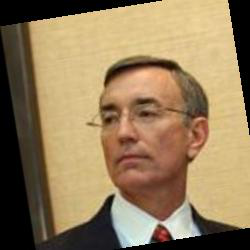

image1


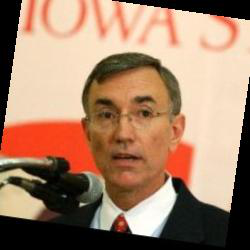

image2
They are the same person?  tensor([0.])

 
 



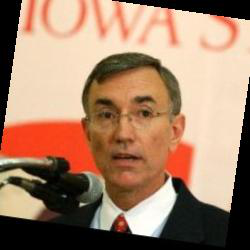

image1


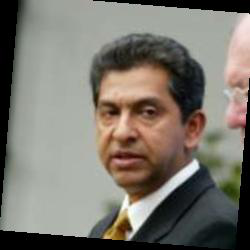

image2
They are the same person?  tensor([1.])

 
 



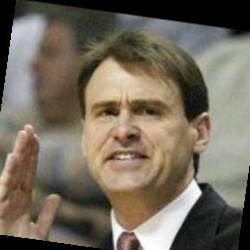

image1


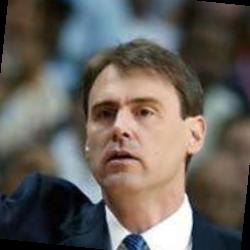

image2
They are the same person?  tensor([0.])

 
 



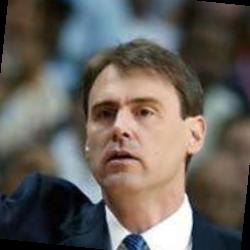

image1


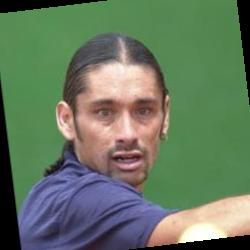

image2
They are the same person?  tensor([1.])

 
 



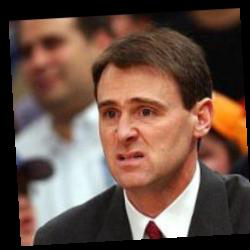

image1


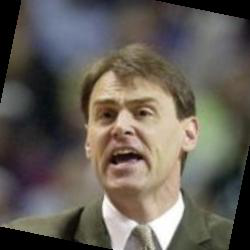

image2
They are the same person?  tensor([0.])

 
 



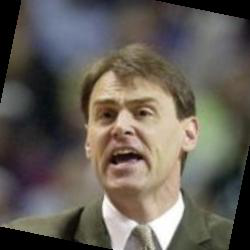

image1


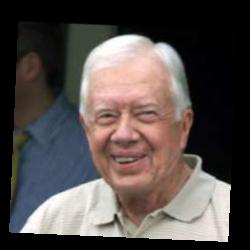

image2
They are the same person?  tensor([1.])

 
 



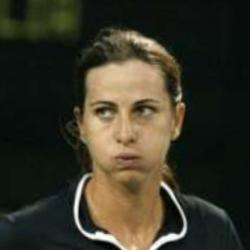

image1


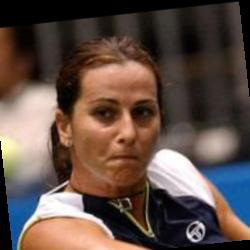

image2
They are the same person?  tensor([0.])

 
 



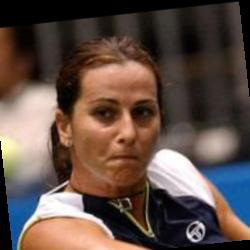

image1


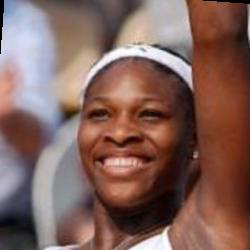

image2
They are the same person?  tensor([1.])

 
 



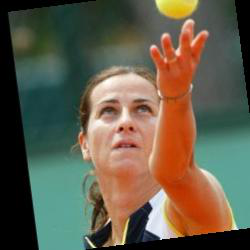

image1


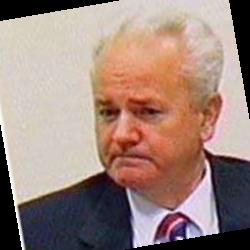

image2
They are the same person?  tensor([0.])

 
 



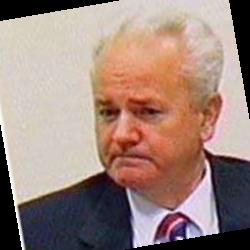

image1


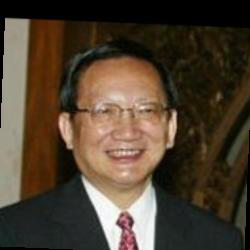

image2
They are the same person?  tensor([1.])


In [4]:
#some images

from PIL import Image
import numpy as np

c=0
for image1,image2,label in dataset:
    print("\n \n \n")
    display(image1)
    print("image1")
    display(image2)
    print("image2")
    print("They are the same person? ",label)
    c+=1
    if c==10:
        break


In [5]:
#some statistics
print("Number of subjects: ",len(image_map))
pic=0
for val in image_map.values():
    pic += len(val)
print("Total number of pictures: ",pic)
print("Avg pic for each subject: ", pic/len(image_map))

Number of subjects:  1680
Total number of pictures:  9164
Avg pic for each subject:  5.454761904761905


In [6]:
#DataLoader info
import multiprocessing as mp

dataloader = LFW_DataModule(dataset, batch_size=32, splitting_points=(0.11, 0.11), num_workers=mp.cpu_count())
dataloader.setup()
train_loader = dataloader.train_dataloader()
val_loader = dataloader.val_dataloader()
test_loader = dataloader.test_dataloader()

print("Batch_size: ", train_loader.batch_size)
print("Sampler info: ", train_loader.sampler)
print("Train loader length: ",len(train_loader))
print("Validation loader length: ",len(val_loader))
print("Test loader length: ",len(test_loader))

[7148, 1008, 1008]
Batch_size:  32
Sampler info:  <torch.utils.data.sampler.RandomSampler object at 0x7f03e90460d0>
Train loader length:  224
Validation loader length:  32
Test loader length:  32


max value 1.0
min value 0.0
img size torch.Size([32, 3, 128, 128])
[0. 0. 0. 1. 1.]


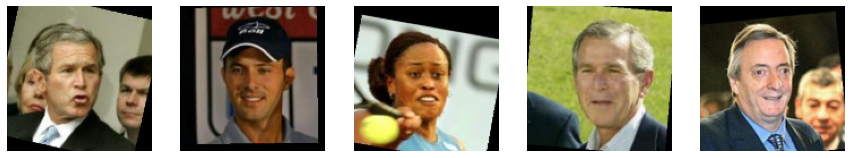

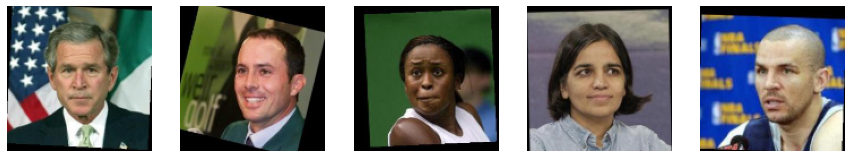

In [7]:
#Dataloader samples
from src.tools.visualization_tools import visualize_torch
import torch

for i, (im1, im2, label) in enumerate(train_loader):
    print('max value', torch.max(im1).item())
    print('min value', torch.min(im1).item())
    print('img size', im1.size())
    visualize_torch(im1[0:5])
    visualize_torch(im2[0:5])
    print(label[0:5].squeeze().numpy())
    
    if i == 0:
        break

# Training the model

In [8]:
image_map = get_dataset_filename_map(max_val = -1)
dataset = LfwImagesDataset(image_map)
print("Number of pictures", len(dataset))

dataloader = LFW_DataModule(dataset, batch_size=16, splitting_points=(0.20, 0.20), num_workers=mp.cpu_count())
dataloader.setup()
train_loader = dataloader.train_dataloader()
val_loader = dataloader.val_dataloader()
test_loader = dataloader.test_dataloader()

Number of pictures 9164
[5500, 1832, 1832]


In [9]:
# %tensorboard --logdir lightning_logs

In [10]:
from src.Model.CustomModel import Siamese
import pytorch_lightning as pl
from src.tools.model_tools import ContrastiveLoss
model_hparams = {
    "loss_fn": ContrastiveLoss(),
    "lr": 0.001,
    "weight_decay":1e-5,
    "filter_channels": 4,
    "filter_size": 3,
    "dropout": 0.02,
    "n_hidden1": 4096,
    "n_hidden2": 2048,
    "n_hidden3": 128,
    'loss_margin': 5,
}

early_stop_callback = pl.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    strict=False,
    verbose=False,
    mode='min'
)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    dirpath='data/checkpoint/margin5',
    filename='Siamese-Contrastive-{epoch:02d}-{val_loss:.2f}',
    save_top_k=5,
    mode='min',
)

trainer_params = {
    "check_val_every_n_epoch": 1, 
    "callbacks": [
        early_stop_callback,
        checkpoint_callback,
    ],
    "fast_dev_run": False,
    "max_epochs": 100,
    "gpus":1 if torch.cuda.is_available() else None,
    
}

do_train = False
model = Siamese(hparams=model_hparams)
trainer = pl.Trainer(**trainer_params)
if do_train:
    trainer.fit(model, dataloader)

/home/kareem/PycharmProjects/whos_that_pokemon/venv/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Checkpoint directory data/checkpoint/margin5 exists and is not empty. With save_top_k=5, all files in this directory will be deleted when a checkpoint is saved!
  warnings.warn(*args, **kwargs)
/home/kareem/PycharmProjects/whos_that_pokemon/venv/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


# Save/Load Checkpoint

## Manual Save

In [11]:
import os

save_checkpoint = False
if save_checkpoint:
    save_dir = os.path.join('data', 'saved')  
    checkpoint_path = os.path.join(save_dir, 'Siamese-Contrastive-last.ckpt')
    trainer.save_checkpoint(checkpoint_path)

## Load Checkpoint

In [12]:
load_checkpoint = True

if load_checkpoint:
    checkpoint_path = checkpoint_callback.best_model_path
    checkpoint_path = os.path.join(checkpoint_callback.dirpath, 'Siamese-Contrastive-epoch=25-val_loss=1.00.ckpt')
    
    model = model.load_from_checkpoint(checkpoint_path=checkpoint_path)
#     x1, x2, label, y = inference(chkpt_model, loader=dataloader.val_dataloader())
#     visualize_torch(x1[:5])
#     visualize_torch(x2[:5])
#     print("labels", label.squeeze()[:5])
#     print("predictions", y.squeeze()[:5])

## Retrain from checkpoint

In [13]:
resume_training = False
if resume_training:
    checkpoint_path = checkpoint_callback.best_model_path
    trainer = Trainer(resume_from_checkpoint=checkpoint_path)
    trainer.fit(model)

# Evaluate Model

## Run validation epoch

In [14]:
trainer.test(model, dataloader.val_dataloader())

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_acc': tensor(0.), 'avg_loss': tensor(0.6553)}
--------------------------------------------------------------------------------



/home/kareem/PycharmProjects/whos_that_pokemon/venv/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The testing_epoch_end should not return anything as of 9.1.to log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)


[{'avg_loss': 0.6552507281303406, 'avg_acc': 0.0}]

## Run test epoch

In [15]:
trainer.test(model, dataloader.test_dataloader())

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_acc': tensor(0.), 'avg_loss': tensor(0.6664)}
--------------------------------------------------------------------------------



[{'avg_loss': 0.6664379239082336, 'avg_acc': 0.0}]

labels tensor([0., 0., 0., 1., 1.])
predictions tensor([0.5139, 0.1951, 0.2566, 1.2719, 0.2896])


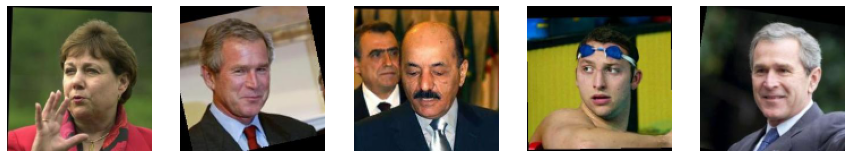

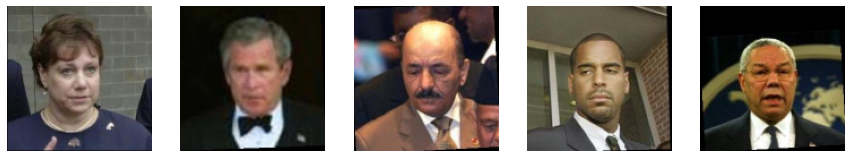

In [16]:
from src.tools.model_tools import inference
from torch.utils import data


for x1, x2, label, y in inference(model, loader=dataloader.val_dataloader()):
    visualize_torch(x1[:5])
    visualize_torch(x2[:5])
    print("labels", label.squeeze()[:5])
    print("predictions", y.squeeze()[:5])
    break

labels tensor([0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1.])
predictions tensor([0.2362, 1.0635, 0.6285, 0.6720, 1.1251, 0.9396, 0.3531, 0.6816, 1.2737,
        1.2705, 1.0252, 2.0233, 1.5728, 1.4269, 0.4415, 2.1260, 0.6336, 1.2805,
        0.6433, 2.1505])


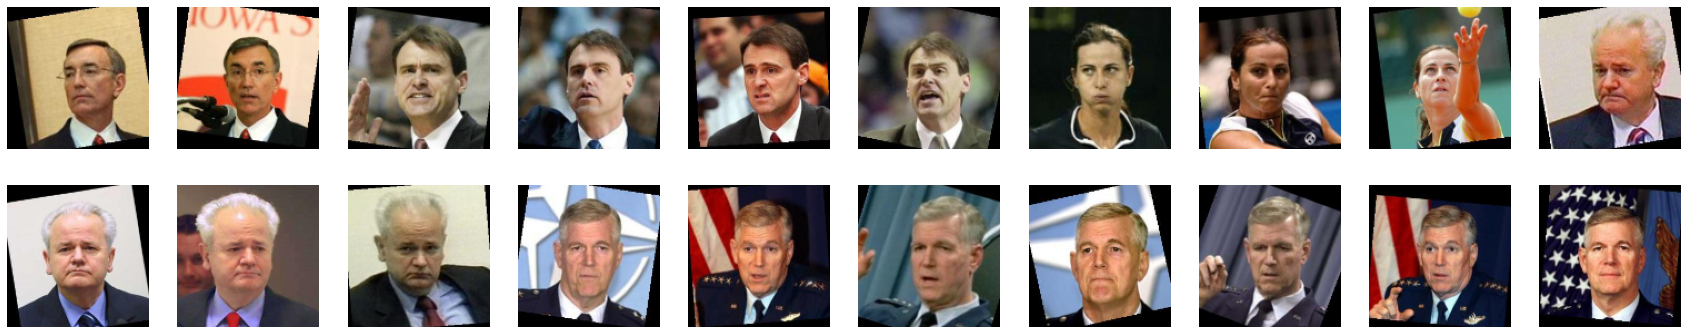

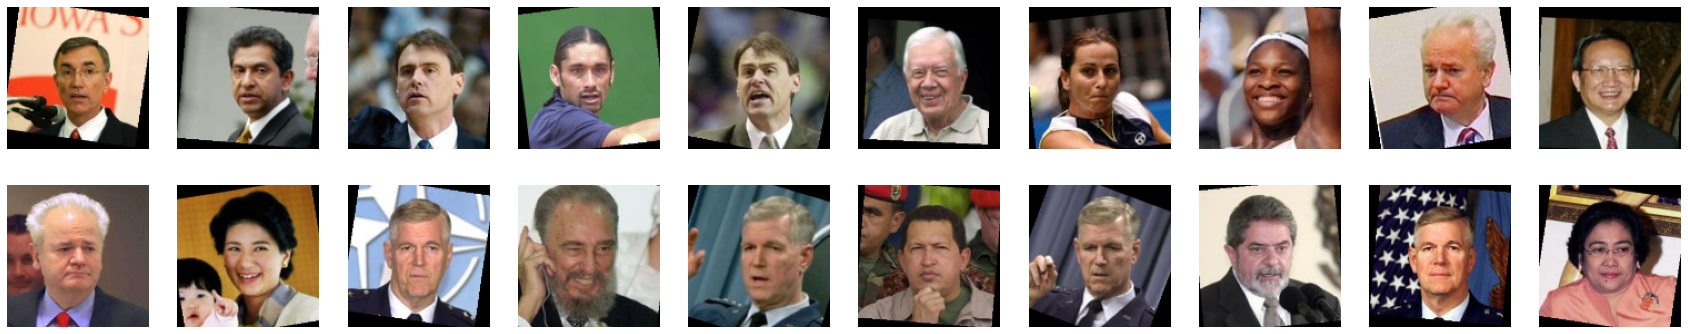

In [17]:
from torchvision import transforms
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((128, 128))
        ])
image_map = get_dataset_filename_map()
dataset = LfwImagesDataset(image_map, transform = transform)


inputs=[]
for i, (image1,image2,label) in enumerate(dataset):
    inputs.append((image1,image2,label))
    if i==20:
        break
        
        
for x1, x2, label, y in inference(model, images=inputs):
    visualize_torch(x1[:20], n_cols=10, n_rows = 2)
    visualize_torch(x2[:20], n_cols=10, n_rows = 2)
    print("labels", label.squeeze()[:20])
    print("predictions", y.squeeze()[:20])


labels tensor([0., 1., 0., 1., 1.])
predictions tensor([0.8253, 2.7170, 0.8586, 0.3009, 2.3083])


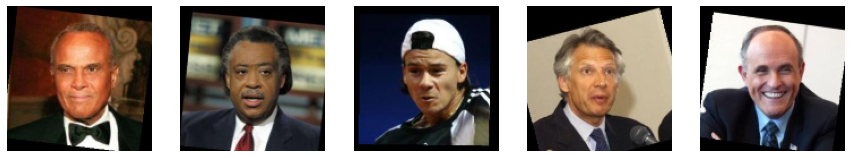

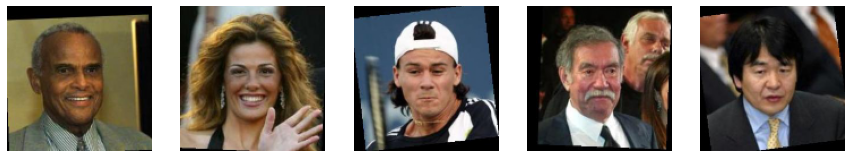

In [18]:
from src.tools.model_tools import inference

for x1, x2, label, y in inference(model, loader=dataloader.test_dataloader()):
    visualize_torch(x1[:5])
    visualize_torch(x2[:5])
    print("labels", label.squeeze()[:5])
    print("predictions", y.squeeze()[:5])
    break